In [2]:
import math
import torch
import matplotlib.pyplot as plt
import torchvision
from google.colab import drive
import torch.nn as nn
#copied from https://github.com/psyrocloud/MS-SSIM_L1_LOSS
drive.mount("/content/drive")
import sys
sys.path.append("/content/drive/MyDrive/MinecraftRecipeGenerativeModelProject")
from MS_SSIM_L1_loss import MS_SSIM_L1_LOSS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


In [ ]:
'''
Macro scale Architecture:
Encoder CNN
Interpreter Vit
Decoder Linear
'''

'\nMacro scale Architecture:\nEncoder CNN\nInterpreter Vit\nDecoder Linear\n'

In [50]:
!cd /content/drive/MyDrive/MinecraftRecipeGenerativeModelProject && git init -b main && git add . && git commit -m "Init" && git remote add origin https://github.com/XiangHaoAlexWang/MinecraftRecipeGenerator.git && git push -u origin main


Streaming output truncated to the last 5000 lines.
 create mode 100644 ExtractedMinecraftFiles/item/clock_08.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_09.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_10.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_11.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_12.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_13.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_14.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_15.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_16.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_17.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_18.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_19.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_20.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_21.png
 create mode 100644 ExtractedMinecraftFiles/item/clock_22.png
 create mode 100644

In [ ]:
def GridPattcher(grid:torch.tensor):
    #3 * 3 grid 3 channels 128*128 pixel
    B=grid.shape[0]
    patches=torch.zeros((B,3,3,4,128,128))
    for i in range(3):
        for j in range(3):
            #print(patches[:,i,j].shape)
            #print(grid[:,:,128*(i):128*(i+1),128*(j):128*(j+1)].shape)
            patches[:,i,j] += grid[:,:,128*(i):128*(i+1),128*(j):128*(j+1)]
    return patches.flatten(start_dim=1,end_dim=2)

In [ ]:
class CNNItemEmbed(nn.Module):
    '''
    Original size 3*128*3*128
    Macro Architecture:
    2dConv (stride 2)
    activations
    maxpool
    dropout
    2dConv (stride 2)
    activations
    maxpool
    2dConv (stride 1)
    prepared patchsize 8
    '''

    def __init__(self):
        super().__init__()
        self.layers=nn.Sequential(nn.Conv2d(4,32,16,2,7),nn.ReLU(),nn.MaxPool2d(2),nn.Dropout(0.1),nn.Conv2d(32,256,4,2,2),nn.ReLU(),nn.MaxPool2d(2),nn.Conv2d(256,512,8,8))

    def forward(self,x):
      return self.layers(x).squeeze()

In [ ]:
def ConcatItemEmbedTest(patches):
    #Dimension test
    dimension_test_model = CNNItemEmbed()
    print(patches.shape)
    PatchesEmbed=[]
    for i in range(patches.shape[1]):
        #print(dimension_test_model(patches[:,i]).shape)
        PatchesEmbed.append(dimension_test_model(patches[:,i]))
    return torch.stack(PatchesEmbed).transpose(0,1)

In [ ]:
#Dimension test
dimension_test_img=torch.ones((10,4,3*128,3*128))
dimension_test_patch = GridPattcher(dimension_test_img)
print(ConcatItemEmbedTest(dimension_test_patch).shape)

torch.Size([10, 9, 4, 128, 128])
torch.Size([10, 9, 512])


In [ ]:
#Mostly similar structure to lab 1b
class CLSPositionalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        num_patches=9
        embed_dim=512

        self.cls_token = nn.Parameter(torch.randn((1,1,embed_dim))*0.02)
        self.pos_embed = nn.Parameter(torch.zeros((1,num_patches+1,embed_dim)))
    def forward(self,x):
        B,N,d=x.shape
        return torch.cat((self.cls_token.expand(B,-1,-1),x),dim=1)+self.pos_embed

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        embed_dim=512
        hidden_dim = 4*embed_dim
        dropout=0.1

        self.fc1 = nn.Linear(embed_dim,hidden_dim)
        self.act = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim,embed_dim)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self,x):
        return self.dropout2(self.fc2(self.dropout1(self.act(self.fc1(x)))))

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        num_patches=9
        embed_dim=512
        num_heads=2
        dropout=0.1

        self.norm1 = nn.LayerNorm((num_patches+1,embed_dim))
        self.attn = nn.MultiheadAttention(embed_dim,num_heads,dropout)
        self.norm2 = nn.LayerNorm((num_patches+1,embed_dim))
        self.mlp = MLP()
    def forward(self,x):
        x=self.norm1(x)
        x=self.norm2(x+self.attn(x,x,x)[0])
        x=x+self.mlp(x)
        return x

In [ ]:
class RecipeInterpreter(nn.Module):
    def __init__(self):
        super().__init__()
        embed_dim=512
        num_patches=9

        self.ItemEmbed = CNNItemEmbed()
        self.cls_pos_embed = CLSPositionalEmbedding()
        self.encoder_blocks = nn.ModuleList([TransformerEncoderBlock() for i in range(8)])
        self.norm = nn.LayerNorm((num_patches+1,embed_dim))
        self.linearDecode1 = nn.Linear(embed_dim,4*32*32)
        self.linearDecode2 = nn.Linear(4*32*32,4*128*128)

    def ConcatItemEmbeds(self,patches):
        print(patches.shape)
        PatchesEmbed=[]
        for i in range(1,patches.shape[1]):
            PatchesEmbed.append(self.ItemEmbed(patches[:,i]))
        return torch.stack(PatchesEmbed).transpose(0,1)

    def forward(self,x):
        x=self.ConcatItemEmbeds(GridPattcher(x))
        print("checkpoint")
        x=self.cls_pos_embed(x)
        for encoder_block in self.encoder_blocks:
            x=encoder_block(x)
        x=self.linearDecode2(self.linearDecode1(self.norm(x)[:,0]))
        return x



In [ ]:
ProjectPath="/content/drive/MyDrive/MinecraftRecipeGenerativeModelProject"

res_images=[]
batch_size=2
for i in range(batch_size):
  id = f"{i:06d}"
  res_images.append(torchvision.io.read_image(ProjectPath+"/crafting_dataset/result/"+id+".png"))
res_images = torch.stack(res_images)

grid_images=[]
for i in range(batch_size):
  id = f"{i:06d}"
  grid_images.append(torchvision.io.read_image(ProjectPath+"/crafting_dataset/grid/"+id+".png"))
grid_images = torch.stack(grid_images)


torch.Size([2, 4, 128, 128])


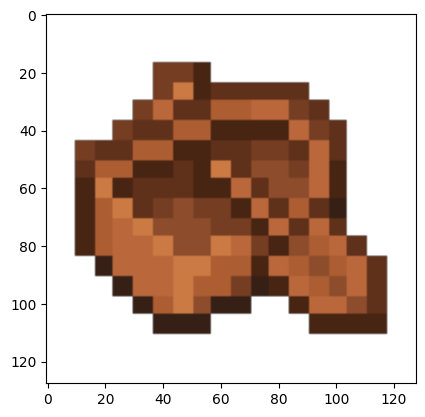

In [ ]:
plt.imshow(res_images[0].transpose(0,1).transpose(1,2))
print(res_images.shape)

torch.Size([2, 4, 384, 384])


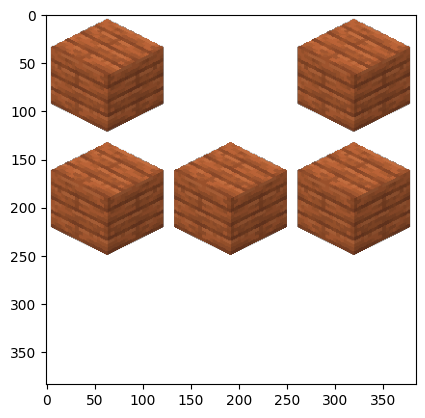

In [ ]:
plt.imshow(grid_images[0].transpose(0,1).transpose(1,2))
print(grid_images.shape)

In [ ]:
model = RecipeInterpreter().to(device)
criterion = MS_SSIM_L1_LOSS()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=0.02)

def train_one_epoch(model,criterion,optimizer,x,y,device):
    total_loss=0
    x=x.to(device).float()
    y=y.to(device).float()
    optimizer.zero_grad()
    res=model(x).reshape(len(x),4,128,128)
    print("checkpoint")
    loss=criterion(res.cuda(),y.cuda())
    loss.backward()
    optimizer.step()
    return loss.item()

train_one_epoch(model,criterion,optimizer,grid_images,res_images,device)

RuntimeError: Cannot access accelerator device when none is available.